
<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/098_Adversarial_Attacks_FGSM.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/98_Adversarial_Attacks_FGSM.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 🏴‍☠️ Adversarial Attacks: Jak zhakować sieć neuronową? (FGSM)

Sieci neuronowe są bardzo wrażliwe na małe zmiany w wejściu.
Metoda **FGSM (Fast Gradient Sign Method)** to "Anti-Learning".

**Normalny Trening:**
$$ W_{new} = W - \alpha \cdot \nabla_W Loss $$
(Zmieniamy wagi w dół zbocza błędu).

**Atak FGSM:**
$$ X_{hacked} = X + \epsilon \cdot \text{sign}(\nabla_X Loss) $$
(Zmieniamy obrazek $X$ w GÓRĘ zbocza błędu).

Dodajemy do obrazka szum, który wygląda jak "kierunek największego błędu".
Dla człowieka to wygląda jak lekki szum. Dla sieci to wygląda jak cechy zupełnie innej klasy (np. małpy).

Użyjemy wytrenowanego modelu **ResNet18** (ImageNet).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO

# Konfiguracja
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPSILON = 0.05 # Siła ataku (im więcej, tym bardziej widoczny szum)

# 1. ŁADUJEMY MODEL (ResNet18 - Pretrained)
model = models.resnet18(weights='IMAGENET1K_V1').to(DEVICE)
model.eval() # Ważne: Wyłączamy Dropout i BatchNorm!

print(f"Model załadowany na {DEVICE}. Gotowy do bycia oszukanym.")

Model załadowany na cuda. Gotowy do bycia oszukanym.


## Pobranie i Przygotowanie Obrazka

Pobierzemy z internetu zdjęcie (np. Labradora).
Musimy je znormalizować tak, jak oczekuje tego ImageNet (średnia i odchylenie).

Obrazek gotowy.


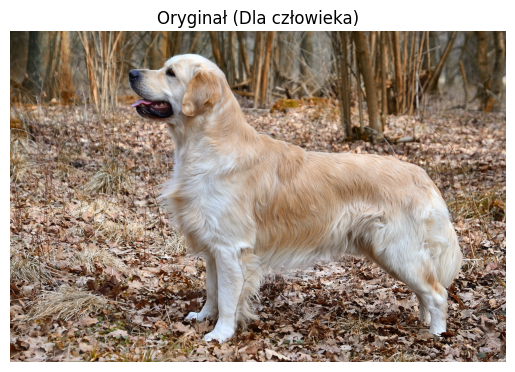

In [5]:
# Link do zdjęcia (Golden Retriever)
url = "https://upload.wikimedia.org/wikipedia/commons/9/93/Golden_Retriever_Carlos_%2810581910556%29.jpg"

# Zapasowy link (gdyby Wikipedia blokowała)
backup_url = "https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg"

# Nagłówek, żeby udawać przeglądarkę (Wiki blokuje boty bez User-Agent)
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}

try:
    response = requests.get(url, headers=headers, timeout=5)
    response.raise_for_status() # Sprawdź czy nie ma błędu 403/404
except Exception as e:
    print(f"⚠️ Błąd pobierania z Wiki: {e}. Używam linku zapasowego...")
    response = requests.get(backup_url)

img_pil = Image.open(BytesIO(response.content))

# Preprocessing (Standard ImageNet)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Normalizacja (Musimy mieć możliwość jej cofnięcia do wyświetlania!)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Przygotowanie tensora
img_tensor = preprocess(img_pil).unsqueeze(0).to(DEVICE)
img_tensor.requires_grad = True # KLUCZOWE: Chcemy liczyć pochodną względem OBRAZKA!

# Nakładamy normalizację
input_tensor = normalize(img_tensor)

print("Obrazek gotowy.")
plt.imshow(img_pil)
plt.axis('off')
plt.title("Oryginał (Dla człowieka)")
plt.show()

In [6]:
# SPRAWDŹMY CO WIDZI MODEL TERAZ
output = model(input_tensor)
pred_idx = output.argmax(dim=1).item()

# Pobierzmy etykiety ImageNet (żeby widzieć nazwy, a nie numery)
labels_url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
labels = requests.get(labels_url).text.splitlines()

print(f"Predykcja przed atakiem: {labels[pred_idx]} (ID: {pred_idx})")
print(f"Pewność: {F.softmax(output, dim=1)[0, pred_idx].item():.4f}")

Predykcja przed atakiem: English setter (ID: 212)
Pewność: 0.6288


## Przeprowadzenie Ataku (FGSM)

1.  Liczymy **Loss** (Błąd). Mówimy modelowi: "To jest Golden Retriever (klasa 207)".
2.  Liczymy **Gradient** względem pikseli wejściowych (`loss.backward()`).
3.  Bierzemy **Znak Gradientu** (`sign()`). To nam mówi: "żeby zwiększyć błąd, ten piksel trzeba rozjaśnić, a tamten ściemnić".
4.  Tworzymy **Zaszumiony Obraz**: Oryginał + Epsilon * Znak.

In [7]:
# 1. Funkcja celu (Chcemy zmylić model co do poprawnej klasy)
target = torch.tensor([pred_idx]).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()

loss = loss_fn(output, target)

# 2. Obliczamy gradient (względem obrazka!)
model.zero_grad()
loss.backward()

# Gradient obrazka
data_grad = img_tensor.grad.data

# 3. FGSM Attack
# sign_data_grad = kierunek, w którym błąd rośnie najszybciej
sign_data_grad = data_grad.sign()

# Tworzymy zaszumiony obrazek
# x_adv = x + epsilon * sign(grad)
perturbed_image = img_tensor + EPSILON * sign_data_grad

# Clipowanie (Piksele muszą być w zakresie 0-1)
perturbed_image = torch.clamp(perturbed_image, 0, 1)

print("Atak wykonany.")

Atak wykonany.


## Wynik Ataku

Teraz przepuścimy ten zaszumiony obrazek przez ten sam model.
Spodziewamy się, że model kompletnie zgłupieje.

In [8]:
# Musimy znowu znormalizować ten zaszumiony obrazek przed podaniem do sieci
perturbed_input = normalize(perturbed_image)

# Predykcja na zhakowanym obrazku
output_adv = model(perturbed_input)
pred_adv_idx = output_adv.argmax(dim=1).item()
confidence_adv = F.softmax(output_adv, dim=1)[0, pred_adv_idx].item()

print("-" * 30)
print(f"Stara klasa: {labels[pred_idx]}")
print(f"NOWA KLASA:  {labels[pred_adv_idx]} 😱")
print(f"Pewność modelu: {confidence_adv:.2%}")

------------------------------
Stara klasa: English setter
NOWA KLASA:  Labrador retriever 😱
Pewność modelu: 28.78%


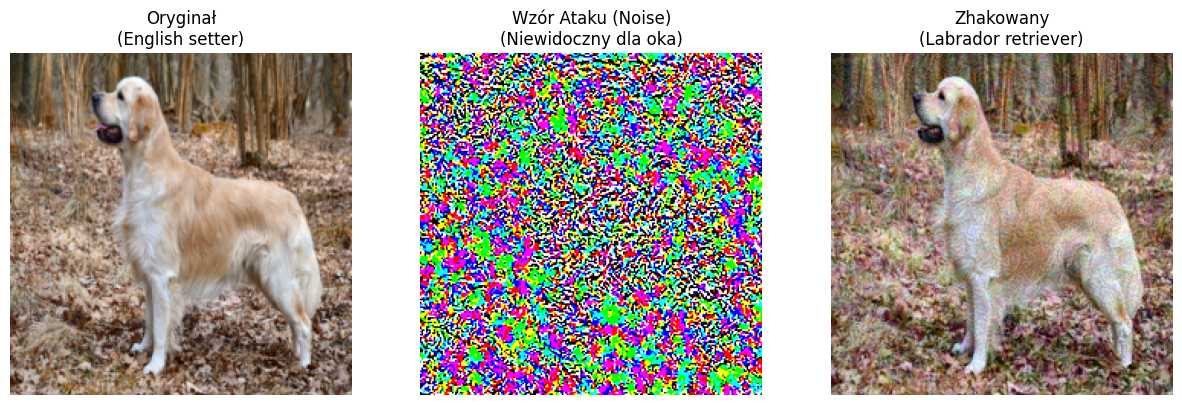

In [9]:
# WIZUALIZACJA PORÓWNAWCZA
# Funkcja do odwracania normalizacji (żeby wyświetlić tensor jako ładny obrazek)
def denormalize(tensor):
    return tensor.squeeze().detach().cpu().permute(1, 2, 0).numpy()

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# 1. Oryginał
ax[0].imshow(denormalize(img_tensor))
ax[0].set_title(f"Oryginał\n({labels[pred_idx]})")
ax[0].axis('off')

# 2. Szum (Wzmocniony, żeby było go widać)
noise = denormalize(sign_data_grad)
# Skalujemy szum do 0-1 dla wyświetlenia
noise = (noise - noise.min()) / (noise.max() - noise.min())
ax[1].imshow(noise, cmap='gray')
ax[1].set_title("Wzór Ataku (Noise)\n(Niewidoczny dla oka)")
ax[1].axis('off')

# 3. Atak
ax[2].imshow(denormalize(perturbed_image))
ax[2].set_title(f"Zhakowany\n({labels[pred_adv_idx]})")
ax[2].axis('off')

plt.show()

## 🧠 Podsumowanie: Dlaczego to straszne?

Spójrz na obrazek nr 1 i nr 3. Dla Ciebie (człowieka) są **identyczne**. To nadal pies.
Dla modelu (AI) obrazek nr 3 to np. "Kort tenisowy" albo "Samolot".

**Konsekwencje:**
1.  **Autonomiczne auta:** Naklejenie specjalnej naklejki (szumu) na znak STOP może sprawić, że Tesla zobaczy go jako ograniczenie prędkości 100 km/h.
2.  **FaceID:** Odpowiedni makijaż lub okulary mogą oszukać system rozpoznawania twarzy.

**Obrona:**
Trenowanie modelu na przykładach zaszumionych (Adversarial Training). To działa jak szczepionka.